# Close Neighbors $d_\mathcal{X}$-privacy frequencies with fix

In [ ]:
import pickle
from os.path import join
import numpy as np
from collections import Counter
from pathlib import Path
import sys

# Add the main directory to sys.path to be able to import config
sys.path.append(str(Path.cwd().parent))
from config import ROOT_DIR
from utils.dx import sample_noise_vectors, noisy_embeddings_to_ids_with_post_processing_fix
from utils.tools import rank_neighbors

# PARAMS
number_of_words = 5000
glove_variant = "6B"  # "6B" or "Twitter"
hidden_size = 300

epsilons = [i for i in range(1, 71)]  # Parameter depending on the GloVe version selected
# END PARAMS

distance_metric = "euclidean"  # Metric to use for the distances
distances_dtype = np.float16  # Precision of the distances
glove_data_folderpath = ROOT_DIR
if glove_variant == "6B":
    glove_dimension_to_filename = {
        50: "glove.6B.50d.pkl",  # 400000 words
        100: "glove.6B.100d.pkl",  # 400000 words
        200: "glove.6B.200d.pkl",  # 400000 words
        300: "glove.6B.300d.pkl",  # 400000 words
    }
elif glove_variant == "Twitter":
    glove_dimension_to_filename = {
        25: "glove.twitter.27B.25d.pkl",  # 1,193,513 words
        50: "glove.twitter.27B.50d.pkl",  # 1,193,513 words
        100: "glove.twitter.27B.100d.pkl",  # 1,193,513 words
        200: "glove.twitter.27B.200d.pkl",  # 1,193,513 words
    }

utils/dx.py contains noisy_embeddings_to_ids_with_post_processing_fix. This function includes the post-processing step after we have found the nearest word $\mathbf{x}^*$ to the noisy embedding $\mathbf{w}^*$. We sort the nearest neighbors of $\mathbf{x}^*$ and output a neighbor proportional to $\exp(- d_\text{NN}(\mathbf{x}^*, \mathbf{x}))$. More specifically any word $\mathbf{x} \in \mathcal{D}$ is output with probability:
$$\frac{\exp(- c \epsilon d_\text{NN}(\mathbf{x}^*, \mathbf{x}))}{\sum_{\mathbf{x} \in \mathcal{D}} \exp(- c \epsilon d_\text{NN}(\mathbf{x}^*, \mathbf{x}))}, 
$$
where $c$ is a constant to control how many neighbors are likely to be selected. A higher value such as $c > 1$ means that the mechanism will output the first few neighbors with high probability, and a lower value such as $c = 0.01$ means that more neighbors will likely to be output, of course, with probability exponentially decreasing as we move away from the original word. This is the same as the temperature variable in the softmax function.

Load GloVe in a specific dimension

In [2]:
with open(
    join(glove_data_folderpath, glove_dimension_to_filename[hidden_size]), "rb"
) as f:
    glove = pickle.load(f)

vocab_embs = np.array(list(glove.values()))
vocab_size = vocab_embs.shape[0]
del glove  # Save RAM

CPU times: user 1.21 s, sys: 1.09 s, total: 2.3 s
Wall time: 2.3 s


Select *number_of_words* random words and rank their neighbors according to their distance with the word in the embedding space.

In [5]:
words_ids = np.random.randint(0, vocab_size, size=number_of_words)
words_embs = vocab_embs[words_ids]

words_neighbors_ranked = rank_neighbors(words_embs, vocab_embs, distance_metric)

CPU times: user 7.47 s, sys: 5.01 s, total: 12.5 s
Wall time: 12.8 s


Add noise to the embeddings of the words following the $d_x$-privacy mechanism. Apply the post-processing described in the paper and count which neighbor was chosen, represented by its rank in the neighbor list of the initial word.

In [ ]:
dx_constant = 0.04  # Parameter
neighbor_counted_occurences = {}

for epsilon in epsilons:
    embeddings = np.copy(words_embs)
    noise = sample_noise_vectors(
        dimension=hidden_size, shape1=1, shape2=number_of_words, epsilon=epsilon
    )[0]
    # Adding noise to embeddings
    noisy_embeddings = embeddings + noise

    # We first find the nearest neighbors of each of the noisy embeddings, called the "pivots" here
    # Then, we apply the post-processing fix proposed in the paper, by sampling a neighbor
    # of each pivot according to the formula above. Finally, w
    noisy_words_ids = noisy_embeddings_to_ids_with_post_processing_fix(
        noisy_embeddings, vocab_embs, dx_constant, epsilon, distance_metric
    )

    # We count the number of times the k-th neighbor has been chosen and store it in neighbor_counted_occurences.

    neighbor_counted_occurences[epsilon] = {}
    # for all words_ids, get the rank k of noisy_word_ids[i] and increase a counter at index k
    noisy_word_ids_ranks = words_neighbors_ranked[
        np.arange(number_of_words), noisy_words_ids
    ]  # This line, for all the elements i in the first dimension of words_neighbors_ranked, gets the particular value pointed by the index which is stored at noisy_word_ids[i]
    noisy_word_ids_ranks_counted = Counter(noisy_word_ids_ranks)
    neighbor_counted_occurences[epsilon][dx_constant] = [
        noisy_word_ids_ranks_counted[k] for k in range(vocab_size)
    ]

CPU times: user 51min 46s, sys: 14min 16s, total: 1h 6min 2s
Wall time: 56min 56s


Results are stored in *neighbor_counted_occurences*, which is a dictionary where the keys are integers representing the value of epsilon. The dictionary associates each epsilon with another dictionary, where the keys are floats representing the value of the constant $c$ in the post-processing fix. This sub-dictionnary associates each $c$ with a list, where list[i] contains the number of times the i-th neighbor was chosen as the replacement of a word. 

Plot

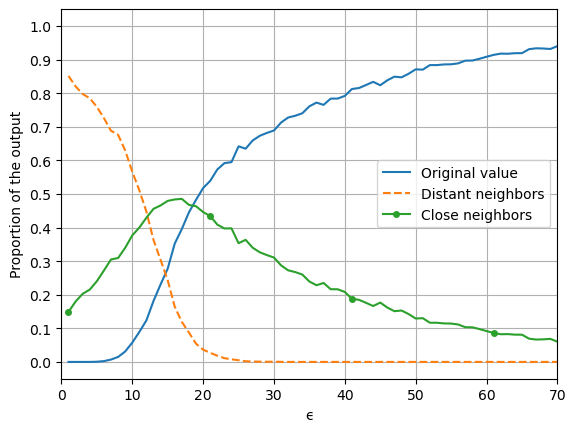

In [8]:
import matplotlib.pyplot as plt
close_neighbors_max_rank = 100 # The maximum rank (including) of what is considered a "close" neighbor 

initial_word_frequency = np.array([neighbor_counted_occurences[i][dx_constant][0] for i in epsilons])
close_neighbors_frequency = np.array([sum(neighbor_counted_occurences[i][dx_constant][1:close_neighbors_max_rank+1]) for i in epsilons])
distant_neighbors_frequency = np.array([sum(neighbor_counted_occurences[i][dx_constant][close_neighbors_max_rank+1:]) for i in epsilons])

fig, ax = plt.subplots()

ax.plot(epsilons, initial_word_frequency/number_of_words, label="Original value", linewidth=1.5)
ax.plot(epsilons, distant_neighbors_frequency/number_of_words, label="Distant neighbors", linewidth=1.5,linestyle='dashed')
ax.plot(epsilons, close_neighbors_frequency/number_of_words, label="Close neighbors", linewidth=1.5, marker=".", markevery=20, markersize=8)

ax.set_xlabel("ϵ")
ax.set_ylabel("Proportion of the output")
ax.set_yticks(np.arange(0, 1.1, 0.1))

ax.set_xticks([i for i in range(0,100,10)])
ax.set_xlim(0,70)
ax.set_ylim(-0.05,1.05)
ax.legend()
ax.grid()

plt.show()